In [ ]:
# Импортируем бибилиотеки

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
# Загружаем тренировочный и тестовый датасеты

train_df = pd.read_csv('Corona_NLP_train.csv', encoding='ISO-8859-1', parse_dates=['TweetAt'])
test_df = pd.read_csv('Corona_NLP_test.csv', encoding='ISO-8859-1',parse_dates=['TweetAt'])

In [3]:
# Проверим данные на наличие пустых или нулевых значений

train_df.isnull().sum(), train_df.isnull().sum()

(UserName            0
 ScreenName          0
 Location         8590
 TweetAt             0
 OriginalTweet       0
 Sentiment           0
 dtype: int64,
 UserName            0
 ScreenName          0
 Location         8590
 TweetAt             0
 OriginalTweet       0
 Sentiment           0
 dtype: int64)

In [4]:
# Смотрим как выглядит датасет
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
# Проверяем размерность

train_df.shape, test_df.shape

((41157, 6), (3798, 6))

In [6]:
# Объединим обучающую и тестовую выборку в один сет для препроцессинга и добавим новую колонку

train_df['is_test'] = 0
test_df['is_test'] = 1
comp_df = pd.concat([train_df, test_df])
comp_df.reset_index(drop=True, inplace=True)
comp_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,is_test
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,0
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,0
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,0
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0
...,...,...,...,...,...,...,...
44950,3794,48746,Israel ??,2020-03-16,Meanwhile In A Supermarket in Israel -- People...,Positive,1
44951,3795,48747,"Farmington, NM",2020-03-16,Did you panic buy a lot of non-perishable item...,Negative,1
44952,3796,48748,"Haverford, PA",2020-03-16,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral,1
44953,3797,48749,NaN,2020-03-16,Gov need to do somethings instead of biar je r...,Extremely Negative,1


In [7]:
# Виды комментариев

comp_df.Sentiment.value_counts()

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

In [8]:
# Очень негативные и очень позитивные просто относим к негативным и позитивным

comp_df['Sentiment'] = comp_df.Sentiment.str.replace('Extremely Positive', 'Positive')
comp_df['Sentiment'] = comp_df.Sentiment.str.replace('Extremely Negative', 'Negative')

Text(0, 0.5, 'Number of tweets')

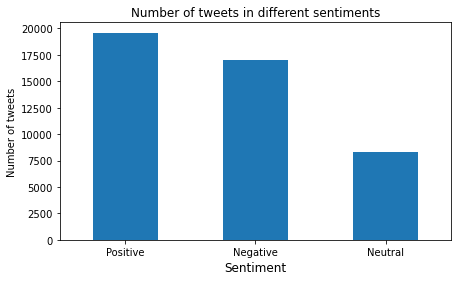

In [9]:
# Визуализируем количество твитов по каждому классу

comp_df.Sentiment.value_counts().plot.bar(figsize=(7,4))
plt.xticks(rotation=None)
plt.title('Number of tweets in different sentiments',fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of tweets')

In [10]:
# Присвом каждому классу числовое значение 2 - позитивный, 0 - негативный, 1 - нейтральный

comp_df['Sentiment'] = comp_df['Sentiment'].map({'Positive':2, 'Negative':0, 'Neutral':1})

In [11]:
# Твиты по месяцам

comp_df['month'] = comp_df['TweetAt'].dt.month

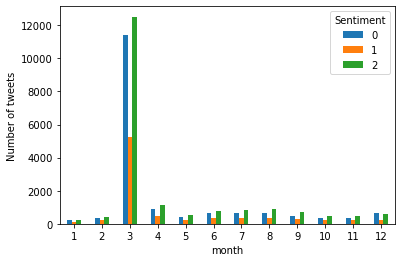

In [12]:
# Твиты по месяцам в виде графика
pd.crosstab(comp_df.month, comp_df.Sentiment).plot.bar()
plt.ylabel('Number of tweets')
plt.xticks(rotation=None)
plt.show()

### препроцессинг

In [13]:
# Удаляем ненужные столбцы

comp_df = comp_df[['OriginalTweet','Sentiment','is_test']]

In [14]:
# создаем переменную с первоначальными твитами
comp_df['OriginalTweet'][31]

"'Hole' Foods...\r\r\n\r\r\n...images from the nicest grocery store in one of the richest neighborhoods in the United States.\r\r\n\r\r\nhttps://t.co/WnQSoMtkVI\r\r\n\r\r\n#BreakingNews #Breaking #Coronavirus #CoronavirusOutbreak #COVID19 #COVID?19 #COVID_19 #COVID2019 #Collapse"

In [15]:
# Для простоты переименуем столбцы

comp_df.columns =['tweet','label','is_test']

In [16]:
#Удалим специальные символы
comp_df.tweet = comp_df.tweet.str.replace(r'(@\w*)','')

#Удалим ссылки
comp_df.tweet = comp_df.tweet.str.replace(r"http\S+", "")

# Удалим хэштеги
comp_df.tweet = comp_df.tweet.str.replace(r'#\w+',"")

#Удалим все что не относитмя к символам
comp_df.tweet = comp_df.tweet.str.replace(r"[^a-zA-Z ]","")

# Удалим лишние пробелы
comp_df.tweet = comp_df.tweet.str.replace(r'( +)'," ")
comp_df.tweet = comp_df.tweet.str.strip()

# Поменяем заглавные на прописные буквы
comp_df.tweet = comp_df.tweet.str.lower()

C:\Users\UMP\anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [17]:
# Добавим новый "обработанный" столбец
#Лемотизируем текст, т.е. приведем каждое слово в его первоначальную форму
comp_df['corpus'] = [nltk.word_tokenize(text) for text in comp_df.tweet]
lemma = nltk.WordNetLemmatizer()
comp_df.corpus = comp_df.apply(lambda x: [lemma.lemmatize(word) for word in x.corpus], axis=1)
comp_df.corpus = comp_df.apply(lambda x: " ".join(x.corpus),axis=1)

comp_df_positive = comp_df[comp_df.label == 2]
comp_df_positive = comp_df_positive.corpus

comp_df_negative = comp_df[comp_df.label == 0]
comp_df_negative = comp_df_negative.corpus

comp_df

<ipython-input-17-05e0abeb99d4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df['corpus'] = [nltk.word_tokenize(text) for text in comp_df.tweet]


,tweet,label,is_test,corpus
0,and and,1,0,and and
1,advice talk to your neighbours family to excha...,2,0,advice talk to your neighbour family to exchan...
2,coronavirus australia woolworths to give elder...,2,0,coronavirus australia woolworth to give elderl...
3,my food stock is not the only one which is emp...,2,0,my food stock is not the only one which is emp...
4,me ready to go at supermarket during the outbr...,0,0,me ready to go at supermarket during the outbr...
...,...,...,...,...
44950,meanwhile in a supermarket in israel people da...,2,1,meanwhile in a supermarket in israel people da...
44951,did you panic buy a lot of nonperishable items...,0,1,did you panic buy a lot of nonperishable item ...
44952,asst prof of economics was on talking about he...,1,1,asst prof of economics wa on talking about her...
44953,gov need to do somethings instead of biar je r...,0,1,gov need to do somethings instead of biar je r...


In [18]:
# Уберем стоп-слова

stop_words = stopwords.words('english')

In [19]:
# Визуализируем наиболее популярные слова из датасета с помощью worldcloud
text = comp_df.corpus.values
wordcloud = WordCloud(max_words=500,background_color='white', stopwords=stop_words, colormap='rainbow',height=300)
wordcloud.generate(str(text))

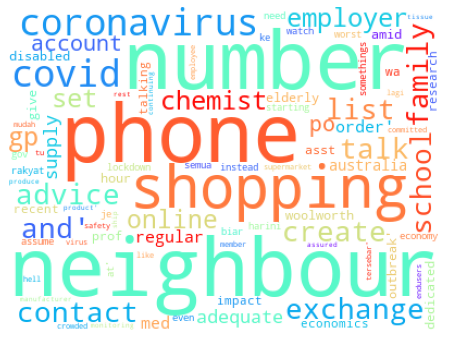

In [20]:
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(10)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [21]:
# Выведем топ-20 слов позитивных комментариев
text = comp_df_positive.values
wordcloud = WordCloud(max_words=20,background_color='white', stopwords=stop_words, colormap='rainbow',height=300)
wordcloud.generate(str(text))

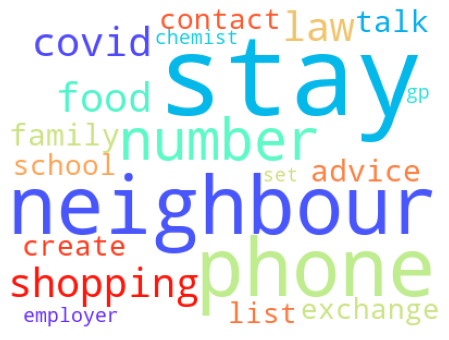

In [22]:
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(10)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [23]:
# Выведем топ-20 слов негативных комментариев
text = comp_df_negative.values
wordcloud = WordCloud(max_words=20,background_color='white', stopwords=stop_words, colormap='rainbow',height=300)
wordcloud.generate(str(text))

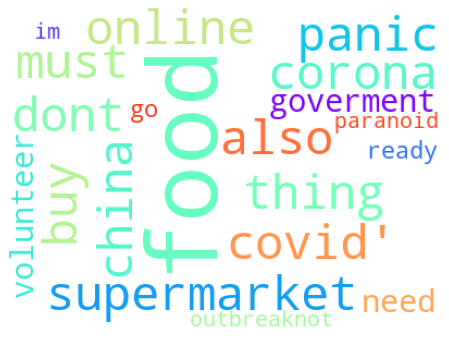

In [24]:
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(10)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Модель

In [25]:
# Подключаем библиотеки
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report

In [26]:
# Делим данные на тестовые и тренировочные наборы

train_df = comp_df[comp_df.is_test==0]
test_df = comp_df[comp_df.is_test==1]
train_df.drop('is_test',axis=1, inplace=True)
test_df.drop('is_test',axis=1, inplace=True)
test_df.reset_index(drop=True,inplace=True)

C:\Users\UMP\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [27]:
x_df = train_df.corpus
y_df = train_df['label'] кр сод

x_test = test_df.corpus
y_test = test_df['label'] прим

# Валидация
x_train, x_val, y_train, y_val = train_test_split(x_df,y_df, test_size=0.2,random_state=42)

In [28]:
# Проверяем параметры
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((32925,), (8232,), (32925,), (8232,))

In [29]:
# Используем CountVectorizer
vectorizer = CountVectorizer(stop_words='english',ngram_range=(1,2),min_df=5).fit(comp_df.corpus)

x_train_vector = vectorizer.transform(x_train)
x_val_vector = vectorizer.transform(x_val)

In [30]:
# тренируем модель
cross_val_score(LogisticRegression(random_state=42), x_train_vector, y_train, cv=10, verbose=1, n_jobs=-1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.2s finished


0.7939258189340104

In [31]:
cross_val_score(MultinomialNB(alpha=0.01), x_train_vector, y_train, cv=10, verbose=1, n_jobs=-1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished


0.6661198281711749

In [32]:
# позитивный(2), негативный(0) и нейтральный (1)

model = LogisticRegression(random_state=42).fit(x_train_vector, y_train)
print(classification_report(y_val, model.predict(x_val_vector),target_names = ['NEGATIVE','NEUTRAL','POSITIVE']))

              precision    recall  f1-score   support

    NEGATIVE       0.81      0.79      0.80      3062
     NEUTRAL       0.70      0.74      0.71      1553
    POSITIVE       0.83      0.84      0.83      3617

    accuracy                           0.80      8232
   macro avg       0.78      0.79      0.78      8232
weighted avg       0.80      0.80      0.80      8232



C:\Users\UMP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
# пробуем TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1,2),stop_words='english').fit(comp_df.corpus)

x_train_tf = vectorizer.transform(x_train)
x_val_tf = vectorizer.transform(x_val)

<AxesSubplot:>

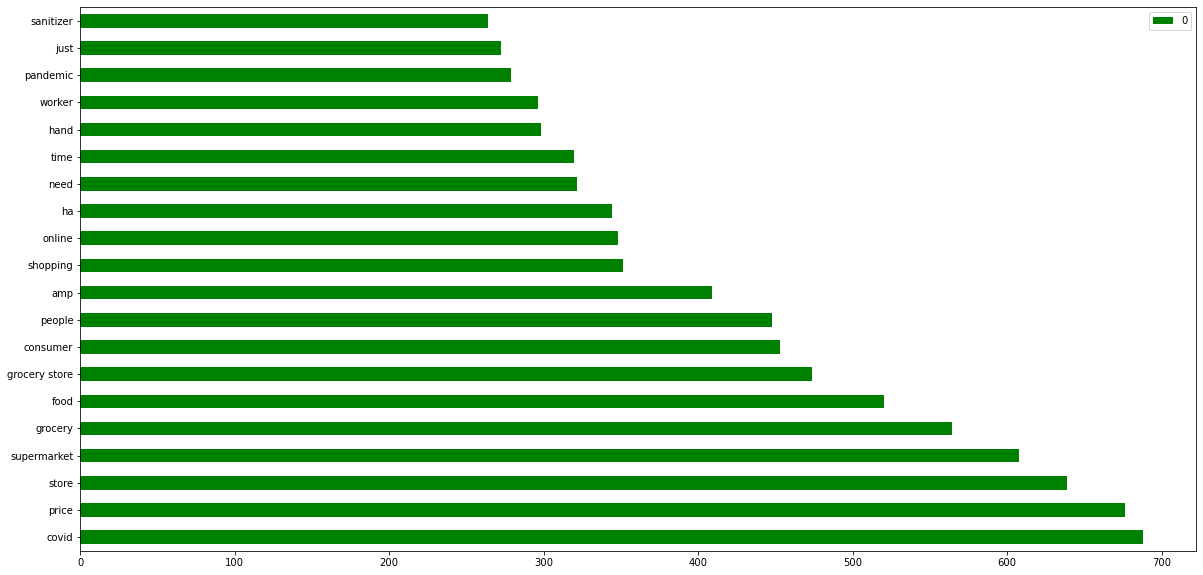

In [34]:
# отображаем топ 20 слов
feature_weight = x_train_tf.sum(axis=0).tolist()[0]
features = pd.DataFrame(feature_weight)
features.index =  list(vectorizer.get_feature_names())
features.sort_values(by=[0],ascending=False).head(20).plot.barh(figsize=(20,10),color = 'green')

In [35]:
# обучаем модель. Используем классификатор LogisticRegression, т.к. она хорошо подходит для разреженных данных
model = LogisticRegression(random_state=1).fit(x_train_tf,y_train)
print(classification_report(y_val, model.predict(x_val_tf)))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      3062
           1       0.74      0.60      0.66      1553
           2       0.80      0.85      0.83      3617

    accuracy                           0.79      8232
   macro avg       0.78      0.75      0.76      8232
weighted avg       0.79      0.79      0.78      8232



C:\Users\UMP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
# Предсказание на тестовом наборе

best_model = LogisticRegression(C=1, penalty='l1', random_state=42, solver='saga')
best_model.fit(x_train_tf, y_train)

C:\Users\UMP\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(C=1, penalty='l1', random_state=42, solver='saga')

### проверка результатов

In [37]:
# Лучший результат
print(classification_report(y_val, best_model.predict(x_val_tf)))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      3062
           1       0.72      0.82      0.77      1553
           2       0.87      0.85      0.86      3617

    accuracy                           0.83      8232
   macro avg       0.81      0.83      0.82      8232
weighted avg       0.83      0.83      0.83      8232



In [38]:
x_test_tf = vectorizer.transform(x_test)

In [39]:
y_pred = best_model.predict(x_test_tf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1633
           1       0.67      0.77      0.72       619
           2       0.83      0.84      0.83      1546

    accuracy                           0.80      3798
   macro avg       0.78      0.80      0.79      3798
weighted avg       0.81      0.80      0.80      3798



0.4126547609191339

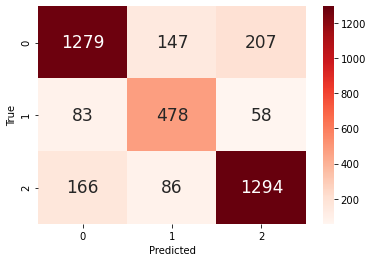

In [40]:
# Визуализируем результат с помощью тепловой карты
# Предсказательная способность модели не самая высокая, но все же неплохая

from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',annot_kws={'size':17}, cmap='Reds')
plt.ylabel('True')
plt.xlabel('Predicted')

r2_score(y_test, y_pred)